# Práctica 2 - Curvas de luz de galaxias cercanas

## Carga de paquetes y definición de funciones

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy import units as u
from astropy.cosmology import Planck18 as cosmo
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
import astropy.constants as c
from astropy.utils.data import get_pkg_data_filename
from astropy.wcs import WCS

from astropy.stats import sigma_clipped_stats
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.datasets import make_100gaussians_image
from astropy.visualization import MinMaxInterval, SqrtStretch, ImageNormalize, ZScaleInterval, LogStretch, simple_norm

import tarfile
import os
import sys
import shutil

from ftplib import FTP

In [12]:
#Aspecto de las figuras
%matplotlib inline
%config InlineBackend.figure_format = 'png'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.labeltop'] = plt.rcParams['ytick.labelright'] = False
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"],'font.size': 18, 'axes.linewidth': 3})
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'CMU Serif'
plt.rcParams['mathtext.it'] = 'CMU Serif:italic'
plt.rcParams['mathtext.bf'] = 'CMU Serif:bold'

plt.rc('legend',fontsize='small') # fuente de leyenda

In [14]:
def plot_fotom(name, name_ref, anchura, obj, banda, center, coords, norm_percent, norm_power, flip=False):
    #carga de datos  
    hdu_ref = fits.open(name_ref)[1] #carga imágen de referencia
    dat_ref = hdu_ref.data
    
    hdu = fits.open(name)[1] #carga imágen de ciencia [1]
    dat = hdu.data
    wcs = WCS(hdu)
    
    x,y         = wcs.all_world2pix(coords.ra, coords.dec, 0)
    x_ref,y_ref = center[0], center[1]
    
    plot_data_ref = hdu_ref.data[int(y_ref)-anchura:int(y_ref)+anchura,int(x_ref)-anchura:int(x_ref)+anchura]
    plot_data     = hdu.data[int(y)-anchura:int(y)+anchura,int(x)-anchura:int(x)+anchura]
    
    if flip == True:
        plot_data_ref = np.flip(plot_data_ref, axis=0)
        plot_data     = np.flip(plot_data, axis=0)
    
    #PLOT DE REFERENCIA
    norm   = simple_norm(plot_data_ref, percent=100 ,stretch = 'power', power=1)
    fig,ax = plt.subplots(figsize=[10,12])
    ax.contour(plot_data_ref ,origin='lower', colors=['skyblue'])
    ax.imshow(plot_data_ref, norm=norm, origin='lower', cmap='afmhot')
    #ax.grid(color='white', ls='dashed', alpha = 0.3)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)
    #fig.suptitle(f'{obj} | {banda}', y=0.88)
    fig.savefig(f'{obj}_{banda}_ref')
    
    
    #PLOT DE RESULTADO
    norm    = simple_norm(dat, percent=norm_percent ,stretch = 'power', power=norm_power)
    anchura = anchura

    fig,ax = plt.subplots(figsize=[10,12])
    #ax = plt.subplot(projection=wcs)
    ax.contour(plot_data_ref ,origin='lower', colors=['skyblue'], alpha=1)
    ax.imshow(plot_data, 
              origin='lower', norm=norm, cmap='afmhot')
    ax.grid(color='white', ls='dashed', alpha = 0.3)
    ax.set_xlabel('Right Ascension (J2000)')
    ax.set_ylabel('Declinaction (J2000)')
    ax.axes.yaxis.set_visible(False)
    ax.axes.xaxis.set_visible(False)

    #PLOT COMPARACIÓN
    #creo layout
    fig     = plt.figure(figsize=[12,12])
    widths  = [5, 1]
    heights = [5, 1]
    gs = fig.add_gridspec(ncols = 2, nrows = 2, wspace=0.3, hspace=0.3, width_ratios=widths, height_ratios=heights)
    fig.suptitle(f'{obj} | {banda}', y=0.93)
    ax = fig.add_subplot(gs[0, 0],projection=wcs)
    #ax.set_yticks([]);
    #ax.set_xticks([]);

    ax_spec_y = fig.add_subplot(gs[0, 1])
    ax_spec_y.set_yticks([]);
    ax_spec_y.set_xticks([]);

    ax_spec_x = fig.add_subplot(gs[1, 0])
    ax_spec_x.set_yticks([]);
    ax_spec_x.set_xticks([]);

    #ploteo figura principal junto a contorno de referencia
    ax.contour(plot_data_ref ,origin='lower', colors=['skyblue'], alpha=1)
    ax.imshow(plot_data, 
              origin='lower', norm=norm, cmap='afmhot')
    ax.grid(color='white', ls='dashed', alpha = 0.4)
    ax.set_xlabel('Right Ascension (J2000)')
    ax.set_ylabel('Declinaction (J2000)')

    #ploteo histograma x de resultado
    hist = np.sum(plot_data,axis=0)/np.max(np.sum(plot_data,axis=0)) - np.min(np.sum(plot_data,axis=0)/np.max(np.sum(plot_data,axis=0)))
    hist = -hist / np.max(abs(hist))
    ax_spec_x.bar(np.arange(len(np.sum(plot_data,axis=0))),
                  hist, color = 'orange')
    ax_spec_x.set_ylim([-1,-np.min(np.sum(plot_data,axis=0))/np.max(np.sum(plot_data,axis=0))])
    ax_spec_x.set_facecolor('grey')


    #ploteo histograma x de referencia
    hist = np.sum(plot_data_ref,axis=0)/np.max(np.sum(plot_data_ref,axis=0)) - np.min(np.sum(plot_data_ref,axis=0)/np.max(np.sum(plot_data_ref,axis=0)))
    hist = -hist / np.max(abs(hist))
    ax_spec_x.bar(np.arange(len(np.sum(plot_data_ref,axis=0))),
                  hist, color = 'white', alpha=0.5)
    ax_spec_x.set_facecolor('grey')


    #ploteo histograma y de resultado
    hist = np.sum(plot_data,axis=1)/np.max(np.sum(plot_data,axis=1)) - np.min(np.sum(plot_data,axis=1)/np.max(np.sum(plot_data,axis=1)))
    hist = hist / np.max(abs(hist))
    ax_spec_y.barh(np.arange(len(np.sum(plot_data,axis=1))),
                  hist,color = 'orange',label='mirage')
    ax_spec_y.set_xlim([np.min(np.sum(plot_data,axis=1))/np.max(np.sum(plot_data,axis=1)),1])
    ax_spec_y.set_facecolor('grey')



    #ploteo histograma y de referencia
    hist = np.sum(plot_data_ref,axis=1)/np.max(np.sum(plot_data_ref,axis=1)) - np.min(np.sum(plot_data_ref,axis=1)/np.max(np.sum(plot_data_ref,axis=1)))
    hist = hist / np.max(abs(hist))
    ax_spec_y.barh(np.arange(len(np.sum(plot_data_ref,axis=1))),
                  hist,color = 'white', alpha=0.5,label='input')
    ax_spec_y.set_facecolor('grey')
    legend = ax_spec_y.legend(bbox_to_anchor=(1.1, -0.1))
    frame = legend.get_frame()
    frame.set_facecolor('grey')
    
    fig.savefig(f'{obj}_{banda}')
    

In [15]:
def fotom(name, coords, r, r_in, r_out, banda):
    img = fits.open(name)['SCI'] #cargo datos de ciencia
    dat = img.data
    wcs = WCS(img)  
    x,y = wcs.all_world2pix(coords.ra, coords.dec, 0)
    positions = [(x,y)]
    aperture = CircularAperture(positions, r=r)  
    annulus_aperture = CircularAnnulus(positions, r_in=r_in, r_out=r_out)
    annulus_masks = annulus_aperture.to_mask(method='center')
    bkg_median = []
    bkg_std = []

    for mask in annulus_masks:
        annulus_data = mask.multiply(dat)
        annulus_data_1d = annulus_data[mask.data > 0]
        _, median_sigclip, _ = sigma_clipped_stats(annulus_data_1d)
        bkg_median.append(median_sigclip)
        bkg_std = np.std(annulus_data_1d)
        n_pix_back = len(annulus_data_1d)

    bkg_std = np.array(bkg_std)
    bkg_median = np.array(bkg_median)
    phot = aperture_photometry(dat, aperture, wcs=wcs)
    phot['annulus_median'] = bkg_median
    phot['aper_bkg'] = bkg_median * aperture.area
    phot['aper_sum_bkgsub'] = phot['aperture_sum'] - phot['aper_bkg']
    phot['bkg_std_area'] = np.sqrt(bkg_std**2 * aperture.area + aperture.area**2 /n_pix_back * bkg_std**2 ) #error asociado a background
    
    if banda == 'F115W':
        factor = (np.sqrt(0.00094735348) * u.arcsec) ** 2 / u.pixel #área del px en sr
        converted_aperture_sum = (phot['aper_sum_bkgsub']* u.MJy / u.sr * factor).to(u.mJy / u.pixel)  
        print(f'Magnitud en {banda}: {(converted_aperture_sum * u.pixel).to(u.ABmag)}')
    
    if banda == 'F444W' or banda == 'F335M':
        factor = (np.sqrt(0.003972341489354567) * u.arcsec) ** 2 / u.pixel #área del px en sr
        converted_aperture_sum = (phot['aper_sum_bkgsub']* u.MJy / u.sr * factor).to(u.mJy / u.pixel)  
        print(f'Magnitud en {banda}: {(converted_aperture_sum * u.pixel).to(u.ABmag)}')
        
    SNR = phot['aper_sum_bkgsub'] / phot['bkg_std_area']
    #SNR = phot['aperture_sum'] / np.sqrt(phot['aper_bkg'])
    print(f'SNR: {SNR.value[0]:.3f}')

In [ ]:
#Para bajar todo el firectorio
with FTP("mrbach.duckdns.org") as ftp:
    ftp.login()
    ftp.cwd('/data')
    ftp.dir()
    filenames = ftp.nlst() # get filenames within the directory
    print(filenames)
    for filename in filenames:
        file = open(filename, 'wb')
        ftp.retrbinary('RETR '+ filename, file.write)
        file.close()
    ftp.quit() # This is the “polite” way to close a connection

In [20]:
#Para bajar archivos en concreto
with FTP("mrbach.duckdns.org") as ftp:
    ftp.login()
    ftp.cwd('/data')
    ftp.dir()
    filenames = ['COS30_F115W.fits', 'COS30_F115W_CLEAR_extended_seed_image.fits'] # get filenames within the directory
    for filename in filenames:
        file = open(filename, 'wb')
        ftp.retrbinary('RETR '+ filename, file.write)
        file.close()
    ftp.quit() # This is the “polite” way to close a connection

-rw-r--r--    1 1000     1000     142367040 Apr 04 11:35 COS30_F115W.fits
-rw-r--r--    1 1000     1000     67124160 Apr 04 11:34 COS30_F115W_CLEAR_extended_seed_image.fits
-rw-r--r--    1 1000     1000     131964480 Apr 04 11:36 COS30_F335M.fits
-rw-r--r--    1 1000     1000     67124160 Apr 04 11:35 COS30_F335M_CLEAR_final_seed_image.fits
-rw-r--r--    1 1000     1000     131964480 Apr 04 11:37 COS30_F444W.fits
-rw-r--r--    1 1000     1000     67124160 Apr 04 11:36 COS30_F444W_CLEAR_final_seed_image.fits
-rw-r--r--    1 1000     1000     143112960 Apr 04 11:38 RCX_F115W.fits
-rw-r--r--    1 1000     1000     67124160 Apr 04 11:37 RCX_F115W_CLEAR_final_seed_image.fits
-rw-r--r--    1 1000     1000     131964480 Apr 04 11:39 RCX_F300M.fits
-rw-r--r--    1 1000     1000     67124160 Apr 04 11:38 RCX_F300M_CLEAR_final_seed_image.fits
-rw-r--r--    1 1000     1000     131964480 Apr 04 11:40 RCX_F444W.fits
-rw-r--r--    1 1000     1000     67124160 Apr 04 11:39 RCX_F444W_CLEAR_final_seed_

## Datos proporcionados

Tenemos a disposición los datos raw y reducidos de observaciones del JWST de un par de galaxias a alto redshift, observados con el intrumento NIRCAM en la campaña GO1:
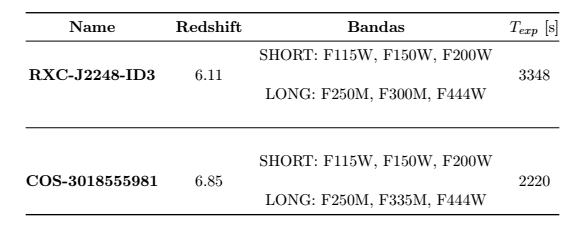

Los datos están dentro de la carpeta `/data` en el directorio del cuaderno

Nuestro objetivo es:
- Determinar la magnitud AB en cada banda. Para ello hay que pasar de uJy/sr a uJy/px y final,ente a ABmag
- Dibujarlos de manera que se aprecie la galaxia bien e introducir contornos sobreimpuestos
- Comparar con los datos que otro equipo ha medido

## Ejemplo con F115W de COS30

### Fotometría de las fuentes

In [20]:
name = './data/COS30_F115W.fits'
name_ref = './data/COS30_F115W_CLEAR_extended_seed_image.fits'
coords = SkyCoord('10h00m30.1850s', '+02d15m59.81s', frame='icrs') #coordenadas de la galaxia
x_ref,y_ref = 801,1072
anchura = 18
obj = 'FL939'
banda = 'F115W'

In [21]:
fotom(name, coords, 18, 25, 35, 'F115W')

Magnitud en F115W: [24.90219229] mag(AB)
SNR: 20.108


### Dibujarlas + contornos

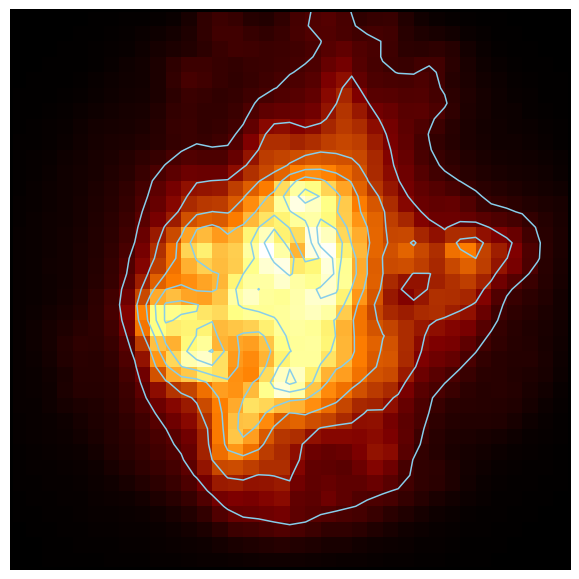

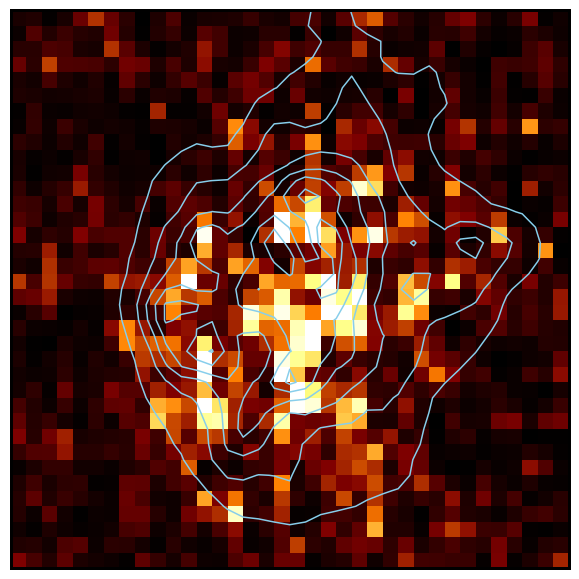

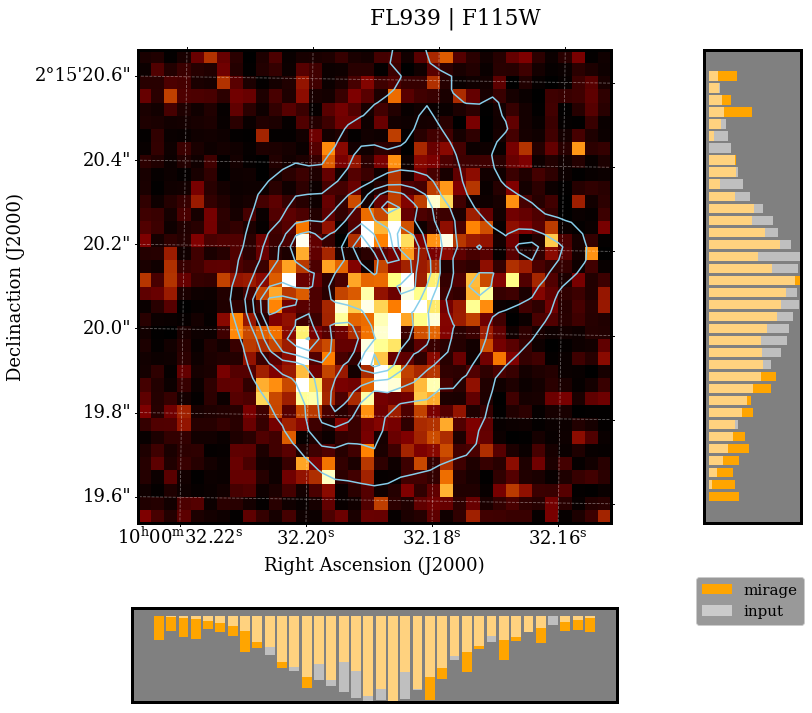

In [23]:
plot_fotom(name, name_ref, anchura, obj, banda, [x_ref,y_ref], coords, 99, 4, flip=True)